# Spam Ham filter using sklearn 

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from textblob import TextBlob

<h2 style="color:blue">Data prepration </h2>
download dataset from https://archive.ics.uci.edu/ml/machine-learning-databases/00228

In [93]:
df = pd.read_csv('./data/SMSSpamCollection' , sep='\t' , names=['status', 'message'])

In [94]:
df.head()

,status,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [95]:
len(df)

5572

In [96]:
len(df[df.status=='spam'])

747

<h2 style="color:blue">Aggregate statistics analysis of data</h2>
Using pandas and matplotlib we can easily anlaysis the dataset 

In [97]:
df.groupby('status').describe()

message                                                               
         count unique                                                top freq
status                                                                       
ham       4825   4516                             Sorry, I'll call later   30
spam       747    653  Please call our customer service representativ...    4

#### how long the message is ?
getting length of each message=>

In [98]:
df['length'] = df['message'].map(lambda msg:len(msg))
df.head()

,status,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


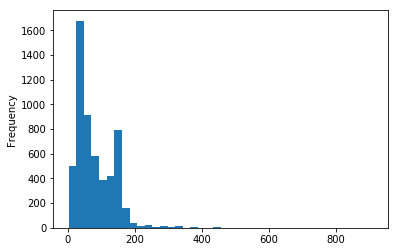

In [99]:
df['length'].plot(bins=40,kind='hist')

In [100]:
#describing message length
print(df['length'].describe())

count    5572.000000
mean       80.616296
std        60.015593
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64


In [101]:
#describing HAM message by length
print('HAM',df['length'].loc[df['status']=='ham'].describe())

('HAM', count    4825.000000
mean       71.558964
std        58.459702
min         2.000000
25%        33.000000
50%        52.000000
75%        93.000000
max       910.000000
Name: length, dtype: float64)


In [102]:
#describing SPAM message by length
print('SPAM',df['length'].loc[df['status']=='spam'].describe())

('SPAM', count    747.000000
mean     139.119143
std       28.998900
min       13.000000
25%      133.000000
50%      149.000000
75%      158.000000
max      224.000000
Name: length, dtype: float64)


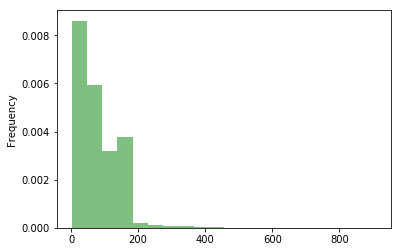

In [103]:
df['length'].plot(kind='hist',bins=20,color='red',facecolor='green',alpha=0.5,normed=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc60d488f90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fc60e3b0b50>], dtype=object)

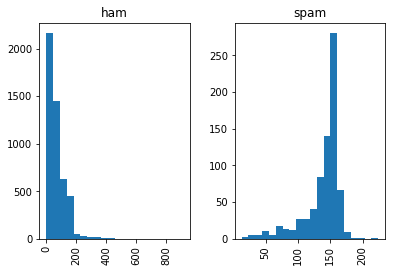

In [104]:
#length difference betwwn SPAM(1) and HAM(0)
df.hist(column='length', by='status', bins=20)

#### getting largest and smallest message

In [105]:
print("Largest messge is:",list(df.message[df.length>900]))  #we can get this 900 from above df.describe
print("Smallest message is ",list(df.message[df.length<3]))  #we can get this 3 from above df.describe

('Largest messge is:', ["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."])
('Smallest message is ', ['Ok', 'Ok', 'Ok', 'Ok'])


### so we can see that most of the SPAM messages are of length 110 to 160

<h2 style="color:blue">Data preprocessing</h2>
It is necessary because we can't apply any Machine learning model on text type data. We we need to tokenize the data.
So we going to conver raw message into vectors.
#### Steps:
1. Split all data into invidual words
2. normalizing data 
3. data to vectors


<p style='color:red'>dependency:</p>
first you need to downlaod **punkt** otherwise it will show you an error.<br>
start python terminal and type<br>
  <code>>>import nltk</code><br>
  <code>>>nltk.download('punkt)</code><br>
  <code>>>nltk.download('wordnet')</code>

#### 1. split into individual words

In [115]:
def split_into_tokens(msg):
    msg = unicode(msg, 'utf8')  # convert bytes into proper unicode
    return TextBlob(msg).words

In [116]:
df.message.head().apply(split_into_tokens)  

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

#### 2.normalize words into their base form which is Lemmatisation
### Lemmatisation of data
The verb ' to go' may appear as 'go', 'goes', 'gone', 'going'. The base form, 'go', that one might look up in a dictionary, is called the lemma for the word.

In [134]:
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

df.message.head().apply(split_into_lemmas)
# print(split_into_lemmas("go goes"))

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

#### 3. Getting vectors from data

In [136]:
df.loc[df["status"]=='ham',"status"]=1
df.loc[df["status"]=='spam',"status"]=0
df.head()

TypeError: invalid type comparison

In [ ]:
df_y = df['status']
df_x = df['message']

In [ ]:
X = np.array(df_x)
y = np.array(df_y)
y=y.astype('int')

In [ ]:
cv = CountVectorizer()

In [ ]:
data = cv.fit_transform(df_x).toarray()
print(data[0:5])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=.9)
# clf = SVC(gamma=.1,C=100)
clf = MultinomialNB()
clf.fit(X_train,y_train)

In [ ]:
clf.score(X_test,y_test)

In [ ]:
p = clf.predict(X_test)

In [ ]:
x = len(p[p==0])

In [ ]:
x

In [ ]:
examples = ['Free Viagra call today!', "I'm going to attend the Linux users group tomorrow.","U dun say so early hor... U c already then"]
# example_counts = data[0]
example_counts = cv.transform(examples)
print(example_counts)
predictions = clf.predict(example_counts)
predictions 